In [2]:
# Install required libraries (if not already installed)
!pip install pandas numpy scikit-learn nltk matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [3]:
# Load the main dataset
df = pd.read_csv('data.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nColumn names:")
print(df.columns)

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

print("\nClass distribution:")
print(df['label'].value_counts())
print("\nClass distribution percentage:")
print(df['label'].value_counts(normalize=True) * 100)


Dataset shape: (39942, 5)

First few rows:
   label                                              title  \
0      1  As U.S. budget fight looms, Republicans flip t...   
1      1  U.S. military to accept transgender recruits o...   
2      1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3      1  FBI Russia probe helped by Australian diplomat...   
4      1  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   

Column names

In [4]:
# Initialize stemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    # Convert to string if not already
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens 
              if word not in stop_words and len(word) > 2]
    
    # Join tokens back into string
    return ' '.join(tokens)

# Apply preprocessing to your text columns
# You can use either 'title', 'text', or combine both
print("Preprocessing text data...")

# Option 1: Use only title
df['cleaned_text'] = df['title'].apply(preprocess_text)

# Option 2: Use only text (article body)
# df['cleaned_text'] = df['text'].apply(preprocess_text)

# Option 3: Combine title and text (often gives better results)
# df['combined'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
# df['cleaned_text'] = df['combined'].apply(preprocess_text)

print("Text preprocessing completed!")
print("\nExample of cleaned text:")
print(df['cleaned_text'].iloc[0])


Preprocessing text data...
Text preprocessing completed!

Example of cleaned text:
budget fight loom republican flip fiscal script


In [5]:
# Prepare features (X) and target (y)
X = df['cleaned_text']
y = df['label']

# Split data into training and testing sets (80-20 split)
# Use stratify to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())


Training set size: 31953
Testing set size: 7989

Training set class distribution:
label
1    15999
0    15954
Name: count, dtype: int64

Testing set class distribution:
label
1    4000
0    3989
Name: count, dtype: int64


In [6]:
#Step 5 

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  # Keep top 5000 most important words
    ngram_range=(1, 3),  # Use unigrams and bigrams
    min_df=2,  # Ignore words appearing in fewer than 2 documents
    max_df=0.8  # Ignore words appearing in more than 80% of documents
)

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")


TF-IDF feature matrix shape: (31953, 20000)
Vocabulary size: 20000


In [15]:
#Step 6

# Train Random Forest with TF-IDF
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,  # Number of trees
    max_depth=80,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate
print("\n=== Random Forest Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Fake', 'Real']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Training Random Forest Classifier...

=== Random Forest Results ===
Accuracy: 0.9161
F1 Score: 0.9199

Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.87      0.91      3989
        Real       0.88      0.96      0.92      4000

    accuracy                           0.92      7989
   macro avg       0.92      0.92      0.92      7989
weighted avg       0.92      0.92      0.92      7989


Confusion Matrix:
[[3471  518]
 [ 152 3848]]


In [8]:
# Train Multinomial Naive Bayes with TF-IDF
 # Train Multinomial Naive Bayes with TF-IDF
print("Training Multinomial Naive Bayes...")
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)


# Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)


# Evaluate
print("\n=== Multinomial Naive Bayes Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_nb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Fake', 'Real']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))


Training Multinomial Naive Bayes...

=== Multinomial Naive Bayes Results ===
Accuracy: 0.9388
F1 Score: 0.9387

Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94      3989
        Real       0.94      0.94      0.94      4000

    accuracy                           0.94      7989
   macro avg       0.94      0.94      0.94      7989
weighted avg       0.94      0.94      0.94      7989


Confusion Matrix:
[[3755  234]
 [ 255 3745]]


In [9]:
#Step 8: Prepare Validation Data and Make Predictions


# Load validation data
validation_df = pd.read_csv('validation_data.csv')

print(f"Validation dataset shape: {validation_df.shape}")
print(validation_df.head())

# Preprocess validation data (same preprocessing as training data)
validation_df['cleaned_text'] = validation_df['title'].apply(preprocess_text)

# Or if you combined title and text during training:
# validation_df['combined'] = validation_df['title'].fillna('') + ' ' + validation_df['text'].fillna('')
# validation_df['cleaned_text'] = validation_df['combined'].apply(preprocess_text)

# Transform using the same vectorizer (fitted on training data)
X_validation = tfidf_vectorizer.transform(validation_df['cleaned_text'])

# Make predictions using your best model
predictions = nb_model.predict(X_validation)

print(f"\nPredictions made: {len(predictions)}")
print(f"Predicted class distribution:")
print(pd.Series(predictions).value_counts())


Validation dataset shape: (4956, 5)
   label                                              title  \
0      2  UK's May 'receiving regular updates' on London...   
1      2  UK transport police leading investigation of L...   
2      2  Pacific nations crack down on North Korean shi...   
3      2  Three suspected al Qaeda militants killed in Y...   
4      2  Chinese academics prod Beijing to consider Nor...   

                                                text    subject  \
0  LONDON (Reuters) - British Prime Minister Ther...  worldnews   
1  LONDON (Reuters) - British counter-terrorism p...  worldnews   
2  WELLINGTON (Reuters) - South Pacific island na...  worldnews   
3  ADEN, Yemen (Reuters) - Three suspected al Qae...  worldnews   
4  BEIJING (Reuters) - Chinese academics are publ...  worldnews   

                  date  
0  September 15, 2017   
1  September 15, 2017   
2  September 15, 2017   
3  September 15, 2017   
4  September 15, 2017   

Predictions made: 4956
Predicte

In [10]:
# Create submission dataframe
# Keep the same format as validation_data.csv
submission_df = validation_df.copy()

# Replace label column with predictions
submission_df['label'] = predictions

# Save to CSV maintaining the original format
# Ensure we only include the required columns in the correct order
output_columns = validation_df.columns.tolist()
submission_df = submission_df[output_columns]

# Save without adding extra index column
submission_df.to_csv('validation_predictions.csv', index=False)

print("Predictions saved to 'validation_predictions.csv'")
print("\nFirst few predictions:")
print(submission_df[['label', 'title']].head(10))


Predictions saved to 'validation_predictions.csv'

First few predictions:
   label                                              title
0      1  UK's May 'receiving regular updates' on London...
1      1  UK transport police leading investigation of L...
2      1  Pacific nations crack down on North Korean shi...
3      1  Three suspected al Qaeda militants killed in Y...
4      1  Chinese academics prod Beijing to consider Nor...
5      1  Flames raced along train at west London statio...
6      1  London police advise people to avoid area near...
7      1  London ambulance service sends hazardous area ...
8      1  Witness says injured in stampede at London sta...
9      1  UK says world will stand together against Nort...


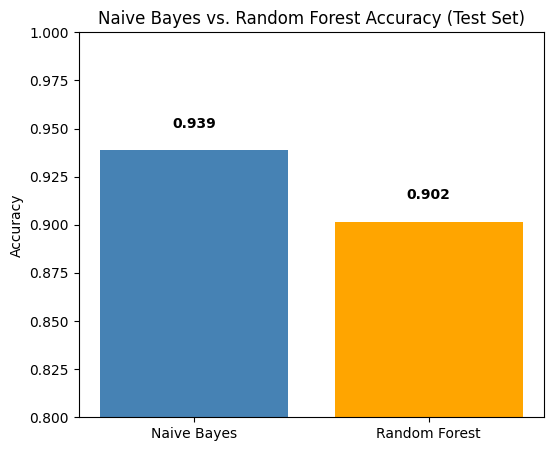

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Assuming you already have:
# - Naive Bayes model predictions: y_pred_nb
# - Random Forest model predictions: y_pred_rf
# - True test labels: y_test

# Calculate accuracies
accuracy_naive_bayes = accuracy_score(y_test, y_pred_nb)
accuracy_random_forest = accuracy_score(y_test, y_pred_rf)

# Prepare data for the bar plot
model_names = ['Naive Bayes', 'Random Forest']
accuracies = [accuracy_naive_bayes, accuracy_random_forest]

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(model_names, accuracies, color=['steelblue', 'orange'])
ax.set_ylim(0.8, 1.0)
ax.set_ylabel('Accuracy')
ax.set_title('Naive Bayes vs. Random Forest Accuracy (Test Set)')

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{acc:.3f}",
            ha='center', va='bottom', fontweight='bold')

plt.show()


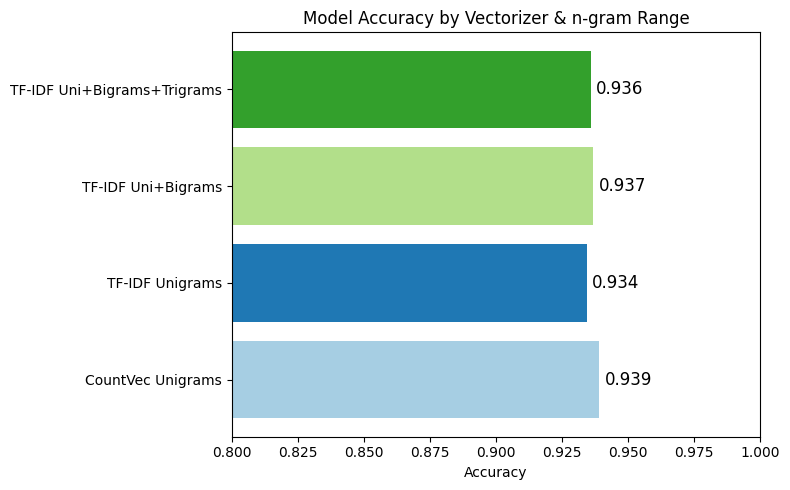

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Make sure your dataset/preprocessing is up (X_train, X_test, y_train, y_test)

# 1. CountVectorizer (unigrams only)
cv_uni = CountVectorizer(ngram_range=(1,1), max_features=10000)
X_train_cv_uni = cv_uni.fit_transform(X_train)
X_test_cv_uni = cv_uni.transform(X_test)
nb_cv_uni = MultinomialNB()
nb_cv_uni.fit(X_train_cv_uni, y_train)
acc_cv_uni = accuracy_score(y_test, nb_cv_uni.predict(X_test_cv_uni))

# 2. TfidfVectorizer (unigrams only)
tfidf_uni = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
X_train_tfidf_uni = tfidf_uni.fit_transform(X_train)
X_test_tfidf_uni = tfidf_uni.transform(X_test)
nb_tfidf_uni = MultinomialNB()
nb_tfidf_uni.fit(X_train_tfidf_uni, y_train)
acc_tfidf_uni = accuracy_score(y_test, nb_tfidf_uni.predict(X_test_tfidf_uni))

# 3. TfidfVectorizer (unigrams + bigrams)
tfidf_bi = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf_bi = tfidf_bi.fit_transform(X_train)
X_test_tfidf_bi = tfidf_bi.transform(X_test)
nb_tfidf_bi = MultinomialNB()
nb_tfidf_bi.fit(X_train_tfidf_bi, y_train)
acc_tfidf_bi = accuracy_score(y_test, nb_tfidf_bi.predict(X_test_tfidf_bi))

# 4. TfidfVectorizer (unigrams + bigrams + trigrams)
tfidf_tri = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
X_train_tfidf_tri = tfidf_tri.fit_transform(X_train)
X_test_tfidf_tri = tfidf_tri.transform(X_test)
nb_tfidf_tri = MultinomialNB()
nb_tfidf_tri.fit(X_train_tfidf_tri, y_train)
acc_tfidf_tri = accuracy_score(y_test, nb_tfidf_tri.predict(X_test_tfidf_tri))

# Now plot them all for comparison
labels = [
    'CountVec Unigrams',
    'TF-IDF Unigrams',
    'TF-IDF Uni+Bigrams',
    'TF-IDF Uni+Bigrams+Trigrams'
]
scores = [
    acc_cv_uni, acc_tfidf_uni, acc_tfidf_bi, acc_tfidf_tri
]

plt.figure(figsize=(8,5))
bars = plt.barh(labels, scores, color=['#a6cee3','#1f78b4','#b2df8a','#33a02c'])
plt.xlabel('Accuracy')
plt.title('Model Accuracy by Vectorizer & n-gram Range')
for bar, score in zip(bars, scores):
    plt.text(score + 0.002, bar.get_y()+bar.get_height()/2, f"{score:.3f}", va='center', fontsize=12)
plt.xlim(0.8, 1.0)
plt.tight_layout()
plt.show()


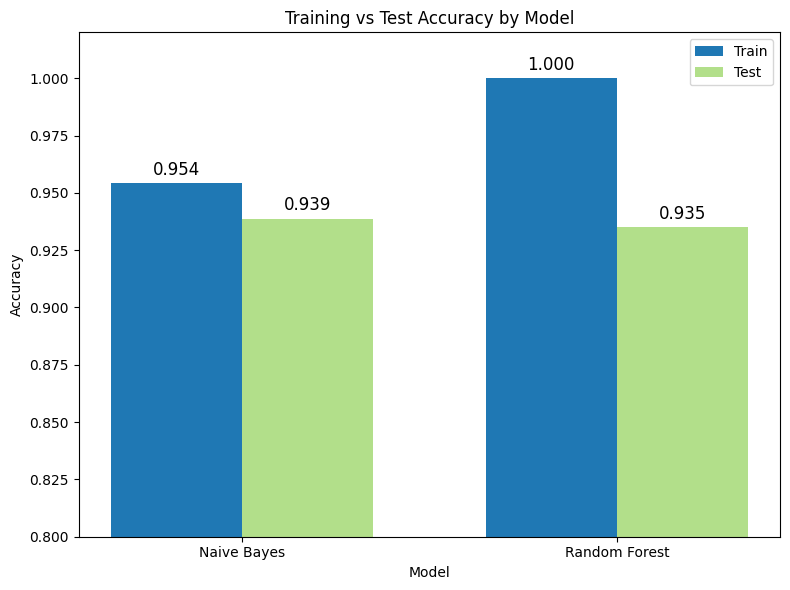

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Assume these variables are defined:
# X_train_tfidf, X_test_tfidf, y_train, y_test

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_train_acc = accuracy_score(y_train, nb.predict(X_train_tfidf))
nb_test_acc = accuracy_score(y_test, nb.predict(X_test_tfidf))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)
rf_train_acc = accuracy_score(y_train, rf.predict(X_train_tfidf))
rf_test_acc = accuracy_score(y_test, rf.predict(X_test_tfidf))

# Data for chart
models = ['Naive Bayes', 'Random Forest']
train_acc = [nb_train_acc, rf_train_acc]
test_acc = [nb_test_acc, rf_test_acc]
bar_width = 0.35
x = np.arange(len(models))

# Grouped bar chart
fig, ax = plt.subplots(figsize=(8,6))
bars1 = ax.bar(x - bar_width/2, train_acc, bar_width, label='Train', color='#1f78b4')
bars2 = ax.bar(x + bar_width/2, test_acc, bar_width, label='Test', color='#b2df8a')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Training vs Test Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.8, max(max(train_acc), max(test_acc)) + 0.02)  # Top a bit above highest accuracy
ax.legend()

# Annotate each bar with value
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

